# A2C Tutorial

In this tutorial we will train an agent using Advantage Actor-Critic (A2C) for the Pendulum-v0 task from `OpenAI Gym <https://gym.openai.com/>`__.

**Task**

The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
[Gym website](https://gym.openai.com/envs/Pendulum-v0).

<img src="https://user-images.githubusercontent.com/8510097/31701471-726f54c0-b385-11e7-9f05-5c50f2affbb4.PNG" alt="Pendulum" style="width: 400px;"/>

This is a continuous control task where the action is a continuous variable of the joint effort. The reward is cost funtion of the observation, and the lowest cost is -16.2736044, while the highest loss is 0. So the reward is always negative. In essence, the goal is maximize the reward, to remain at zero angle (vertical), with the least rotational velocity, and the least effort. More details can be found [here](https://github.com/openai/gym/wiki/Pendulum-v0)

**Algorithm**

We will implement an A2C algorithm for this task. 

In [1]:
%matplotlib inline

In [2]:
import sys
import math
import gym
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
import torchvision.transforms as T
from torch.autograd import Variable
from torch.distributions import Categorical

In [3]:
import gym
env = gym.make("Pendulum-v0")
observation = env.reset()

print(env.action_space)
print(env.observation_space)


for _ in range(200):
  env.render()
  action = env.action_space.sample() # your agent here (this takes random actions)
  observation, reward, done, info = env.step(action)

  if done:
    observation = env.reset()
env.close()


Box(1,)
Box(3,)


In [4]:
class NormalizedActions(gym.ActionWrapper):

    def _action(self, action):
        action = (action + 1) / 2  # [-1, 1] => [0, 1]
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def _reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        action = action * 2 - 1
        return actions

**Actor and Critic networks**

For continuous control tasks, the input into the policy (actor) is the state observation, and we assume the policy $\pi(a|s)$ follows a Gaussian distribution $N(\mu(s), \sigma(s))$. The parameters of the Gaussian are estimated using a policy network. Actions can then be sampled from this distribution.

The critic network will take a state as input, and output a value function estimate of the input state. 

In [5]:

class Actor(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Actor, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2_mu = nn.Linear(hidden_size, num_outputs)
        self.linear2_sigma = nn.Linear(hidden_size, num_outputs)

    def forward(self, inputs):
        x = inputs
        x = F.relu(self.linear1(x))
        mu = self.linear2_mu(x)
        sigma_sq = self.linear2_sigma(x)

        return mu, sigma_sq
    
class Critic(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Critic, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2_value = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        x = inputs
        x = F.relu(self.linear1(x))        
        value = self.linear2_value(x)

        return value

**Actor and Critic network losses**

You will implement the loss functions for the actor and critic networks below.

Recall policy gradients,
$$
J(\theta) = \mathbb{E}_{\tau \sim p(\tau;\theta)}[r(\tau)]
$$

$$
\nabla_\theta J(\theta) \approx \frac{1}{N}\sum_{i=1}^N \sum_{t=1}^T \nabla_\theta \text{log} \pi_\theta (a_t^i|s_t^i) A^\pi (s_t^i, a_t^i)
$$
where $N, T$ represent the number of agent trajectories and episode length, respectively.

We will use n-step rewards for estimating the Q-function in the advantage as follows. 

Let 
$$
y_t^i = \left( \sum_{t'=t}^{t+N-1} \gamma^{t'-t}r(s_{t'}^i, a_{t'}^i) \right) + \gamma^N V_\phi^\pi(s_{t+N}^i) 
$$

We estimate the advantage as
$$
A^\pi (s_{t}^i, a_{t}^i) =  y_t^i - V_\phi^\pi(s_t^i)
$$

The loss function $\mathcal{L}_\theta$ for the actor network is given by
$$
\mathcal{L}_\theta = -\sum_{t=1}^T \text{log} \pi_\theta(a_t|s_t) A^\pi (s_t, a_t)
$$

The critic network is trained to regress to the targets $y_t^i$. The loss function $\mathcal{L}_\phi$ for the critic network is given by
$$
\mathcal{L}_\phi = \sum_{t=1}^T (V_\phi^\pi(s_t^i) - y_t^i)^2
$$

In [6]:
class A2C:
    def __init__(self, hidden_size, num_inputs, action_space, device):
        self.action_space = action_space
        self.actor = Actor(hidden_size, num_inputs, action_space)
        self.critic = Critic(hidden_size, num_inputs, action_space)
        self.actor = self.actor.to(device)
        self.critic = self.critic.to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.device = device

    def normal(self, x, mu, sigma_sq):
        pi = Variable(torch.FloatTensor([math.pi])).to(self.device)
        a = (-1*(Variable(x)-mu).pow(2)/(2*sigma_sq)).exp()
        b = 1/(2*sigma_sq*pi.expand_as(sigma_sq)).sqrt()
        return a*b

   
    def select_action(self, state):
        mu, sigma_sq = self.actor(Variable(state).to(self.device))
        state_value = self.critic(Variable(state).to(self.device))
        #softplus is smooth approximation of RELU to constrain the output to be positive
        sigma_sq = F.softplus(sigma_sq) 

        eps = torch.randn(mu.size())
        # calculate the probability
        action = mu + sigma_sq.sqrt()*Variable(eps)
        action = action.to(device).data
        prob = self.normal(action, mu, sigma_sq)
        pi = Variable(torch.FloatTensor([math.pi])).to(self.device)
        entropy = -0.5*((sigma_sq+2*pi.expand_as(sigma_sq)).log()+1)

        log_prob = prob.log()
        return action, log_prob, state_value, entropy

    def compute_loss(self, rewards, log_probs, state_values, entropies, gamma, Nsteps):

        actor_loss = 0
        critic_loss = 0
        for i in range(len(rewards) - Nsteps):
            R = 0
            for n in range(Nsteps):
                R += (gamma**n) * rewards[i+n]
            R += ((gamma**Nsteps) * state_values[i+Nsteps].item())
            advantage = R - state_values[i].item()
            actor_loss += log_probs[i] * advantage
            actor_loss += 0.0001*entropies[i]
            
            critic_loss += F.mse_loss(state_values[i], torch.tensor([R]))

        self.actor_loss = -actor_loss
        self.critic_loss = critic_loss

        
    def update_parameters(self):
        for loss, optimizer in [(self.actor_loss, self.actor_optimizer), 
                                (self.critic_loss, self.critic_optimizer)]:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


**Training**

According to the pseudo code, we will interact with the environment based on the action from policy network, and collect the episode information to update the actor and critic networks.

/Users/llajan/miniconda2/envs/dlcourse/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class '__main__.NormalizedActions'> doesn't implement 'action' method. Maybe it implements deprecated '_action' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 0, reward: -1502.9509952017638
Episode: 1, reward: -1361.8897920691247
Episode: 2, reward: -1346.0369302288864
Episode: 3, reward: -1536.5899118533835
Episode: 4, reward: -1499.1362564830974
Episode: 5, reward: -1344.7374831375805
Episode: 6, reward: -1556.8344951909148
Episode: 7, reward: -1669.2206412376024
Episode: 8, reward: -1407.4043599634556
Episode: 9, reward: -1044.8107342041571
Episode: 10, reward: -1294.2577546203574
Episode: 11, reward: -1072.6869230083262
Episode: 12, reward: -1318.8803697829076
Episode: 13, reward: -889.278238629191
Episode: 14, reward: -1354.7413371582518
Episode: 15, reward: -1392.227406652572
Episode: 16, reward: -1476.3421944168658
Episode: 17, reward: -1384.424951863231
Episode: 18, reward: -1228.6185473066157
Episode: 19, reward: -1297.7162238239155
Episode: 20, reward: -1406.1178049368582
Episode: 21, reward: -1603.349919662538
Episode: 22, reward: -1296.878572947499
Episode: 23, reward: -1583.0797471439919
Episode: 24, reward: -1444.49233

Episode: 200, reward: -1120.4945321975997
Episode: 201, reward: -1264.6919278128628
Episode: 202, reward: -1341.0318677611165
Episode: 203, reward: -1227.912604147968
Episode: 204, reward: -1491.738328729689
Episode: 205, reward: -1452.5907644582253
Episode: 206, reward: -1523.227020605654
Episode: 207, reward: -1055.3047496930656
Episode: 208, reward: -1570.7334572427196
Episode: 209, reward: -1567.8010060683218
Episode: 210, reward: -1566.1750431772107
Episode: 211, reward: -1438.3224099694069
Episode: 212, reward: -1504.63829120307
Episode: 213, reward: -1515.9936806627006
Episode: 214, reward: -1655.9283554452531
Episode: 215, reward: -1472.6807918692311
Episode: 216, reward: -1536.7223671889328
Episode: 217, reward: -1648.182445564697
Episode: 218, reward: -1157.7198344463109
Episode: 219, reward: -1502.5235213971498
Episode: 220, reward: -1459.4096556204731
Episode: 221, reward: -1402.3781964504294
Episode: 222, reward: -1497.2311155700163
Episode: 223, reward: -1503.714202524029

Episode: 398, reward: -1111.391810263142
Episode: 399, reward: -1157.2772866204505
Episode: 400, reward: -1014.6878154524359
Episode: 401, reward: -1502.034426891115
Episode: 402, reward: -1113.1814517660716
Episode: 403, reward: -1313.819497806137
Episode: 404, reward: -995.4523827963573
Episode: 405, reward: -1022.0354655001806
Episode: 406, reward: -1150.8588161846576
Episode: 407, reward: -906.3437359920368
Episode: 408, reward: -1260.5562518455285
Episode: 409, reward: -760.6958952907612
Episode: 410, reward: -1243.8103132213262
Episode: 411, reward: -988.617820844695
Episode: 412, reward: -996.066238654829
Episode: 413, reward: -1056.8552605962336
Episode: 414, reward: -923.4074731584609
Episode: 415, reward: -1320.9464083004773
Episode: 416, reward: -1216.7726258619937
Episode: 417, reward: -1337.2211177666577
Episode: 418, reward: -1106.412950793454
Episode: 419, reward: -1161.3988988778424
Episode: 420, reward: -1125.9135399147053
Episode: 421, reward: -1273.4377026101242
Epis

Episode: 598, reward: -929.814945962772
Episode: 599, reward: -1317.6270941676053
Episode: 600, reward: -875.3122929455031
Episode: 601, reward: -1149.398198995199
Episode: 602, reward: -1166.7116418622004
Episode: 603, reward: -1047.146139511147
Episode: 604, reward: -886.9400697906578
Episode: 605, reward: -1185.288089486272
Episode: 606, reward: -1185.9402551834164
Episode: 607, reward: -1013.1673440877669
Episode: 608, reward: -1144.5342027794707
Episode: 609, reward: -1328.8341738539275
Episode: 610, reward: -1280.8390173702198
Episode: 611, reward: -1185.5804145878176
Episode: 612, reward: -1261.0332501622404
Episode: 613, reward: -1007.9126799307339
Episode: 614, reward: -1076.952421972339
Episode: 615, reward: -761.5836742642293
Episode: 616, reward: -1140.207377174725
Episode: 617, reward: -1276.2630239377622
Episode: 618, reward: -1187.275834793089
Episode: 619, reward: -766.893052114478
Episode: 620, reward: -1300.3812333548221
Episode: 621, reward: -1043.3264801145804
Episo

Episode: 796, reward: -1184.3407688494171
Episode: 797, reward: -1146.6175678489267
Episode: 798, reward: -905.3223707044357
Episode: 799, reward: -1114.5383977830186
Episode: 800, reward: -900.0181293835146
Episode: 801, reward: -1080.4455435945815
Episode: 802, reward: -754.329857527742
Episode: 803, reward: -1059.067988226923
Episode: 804, reward: -784.5941646121208
Episode: 805, reward: -930.3857394210137
Episode: 806, reward: -1020.6909935812041
Episode: 807, reward: -951.4629372361942
Episode: 808, reward: -1290.105782894314
Episode: 809, reward: -910.2027704887454
Episode: 810, reward: -1451.1766863486619
Episode: 811, reward: -1140.3572505504549
Episode: 812, reward: -1038.3027000013712
Episode: 813, reward: -777.8687225081172
Episode: 814, reward: -915.3047146998799
Episode: 815, reward: -780.4383293542164
Episode: 816, reward: -921.1043345826043
Episode: 817, reward: -1154.328337686101
Episode: 818, reward: -1035.8677269442485
Episode: 819, reward: -1075.7543680411877
Episode

Episode: 996, reward: -1301.8839816076115
Episode: 997, reward: -1103.6440048683626
Episode: 998, reward: -615.7630679215004
Episode: 999, reward: -742.5949831196234


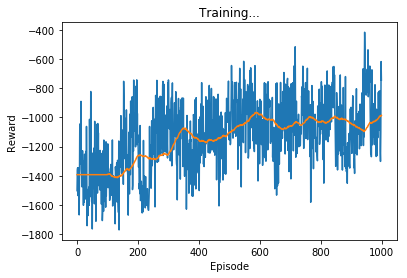

In [7]:
env = gym.make('Pendulum-v0')
#env = gym.make('CartPole-v0')
env = NormalizedActions(env)
env.seed(498)
torch.manual_seed(498)
np.random.seed(498)

device = torch.device('cpu')
agent = A2C(hidden_size=128, num_inputs=env.observation_space.shape[0], action_space=env.action_space, device=device)
reward_list = []
for i_episode in range(1000):
    state = torch.Tensor([env.reset()])
    entropies = []
    log_probs = []
    rewards = []
    state_values = []
    critic_losses = []
    for t in range(1000):
        ## TODO: given the state, get the action from the policy network,
        ## take the action in the environment, put the entropy,log probability
        ## and reward value into the corresponding list, update the state
        action, log_prob, state_value, entropy = agent.select_action(state)
        action = action.cpu()

        next_state, reward, done, _ = env.step(action.numpy()[0])

        entropies.append(entropy)
        log_probs.append(log_prob)
        rewards.append(reward)
        state_values.append(state_value)
        state = torch.Tensor([next_state])
        if done:
            break
    agent.compute_loss(rewards, log_probs, state_values, entropies, gamma=0.99, Nsteps=10)
    agent.update_parameters()
    reward_list.append(np.sum(rewards))
    print("Episode: {}, reward: {}".format(i_episode, np.sum(rewards)))
    
env.close()

import matplotlib.pyplot as plt
reward_list = torch.FloatTensor(reward_list)
plt.figure(2)
plt.plot(reward_list.numpy())
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
if len(reward_list) >= 100:
    means = reward_list.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.ones(99)*means[0], means))
    plt.plot(means.numpy())
plt.show()